# Header

### goal:
Timeseries of t2m forecasts for regional scale

### Regions:

```python
REGION_BOUNDARIES = {
    "L lat": {"lat":slice(-30, 30)},
    "M lat_Austral": {"lat":slice(-60, -30)},
    "M lat_Boreal": {"lat":slice(30, 60)},
    "H lat_Austral": {"lat":slice(-90, -60)},
    "H lat_Boreal": {"lat":slice(60, 90)},
    "S Korea": {"lat": slice(33, 39), "lon": slice(124, 130)}
}
```
$\because$ linearity, averages are calculated per region

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import pickle
from his_preprocess import *
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
from concurrent.futures import ThreadPoolExecutor

REGION_BOUNDARIES = {
    "global": {"lat":slice(-90, 90), "lon":slice(0, 360)},
    "L lat": {"lat":slice(-30, 30)},
    "M lat_Austral": {"lat":slice(-60, -30)},
    "M lat_Boreal": {"lat":slice(30, 60)},
    "H lat_Austral": {"lat":slice(-90, -60)},
    "H lat_Boreal": {"lat":slice(60, 90)},
    "S Korea": {"lat": slice(33, 39), "lon": slice(124, 132)}
}

REGION_BOUNDARIES_NWP = {
    "global": {"lat":slice(90, -90), "lon":slice(0, 360)},
    "L lat": {"lat":slice(30, -30)},
    "M lat_Austral": {"lat":slice(-30, -60)},
    "M lat_Boreal": {"lat":slice(60, 30)},
    "H lat_Austral": {"lat":slice(-60, -90)},
    "H lat_Boreal": {"lat":slice(90, 60)},
    "S Korea": {"lat": slice(39, 33), "lon": slice(124.5, 132)}
}
REGION = ["global", "L lat", "M lat", "H lat", "S Korea"]

colors_list = [
    '#008000', # 초록
    '#FFA500', # 주황
    '#0000FF', # 파랑
    '#800080', # 보라
    '#FF69B4', # 핫핑크
    '#FFD700', # 골드
    '#FF0000', # 빨강
    '#00FF00', # 라임
    '#00FFFF', # 시안
    '#DAA520', # 골든로드
    '#800000', # 마룬
    '#4B0082', # 인디고
    '#8B4513', # 새들브라운
    '#FF4500', # 오렌지레드
    '#00FF7F', # 스프링그린
    '#1E90FF', # 도저블루
    '#FF00FF', # 마젠타
    '#FF1493', # 딥핑크
    '#7B68EE', # 미디엄슬레이트블루
    '#20B2AA', # 라이트시그린
]

scale_list = [0.005, 0.006, 0.007, 0.008, 0.009]

# Data Loading

In [2]:
#@ Loading

with open(f"/data/GC_output/analysis/proportional/zoom_GC_t2m_Globraw.pkl", "rb") as f:
    t2m_perturb = pickle.load(f)

t2m_control = preprocess_GC(xr.open_dataset("/data/GC_output/2021-06-21/GC_output_10.nc"))


FileNotFoundError: [Errno 2] No such file or directory: '/data/GC_output/analysis/proportional/zoom_GC_t2m_Globraw.pkl'

In [3]:
t2m_perturb

NameError: name 't2m_perturb' is not defined

In [20]:
nwp = xr.open_dataset(f"/data/GC_output/analysis/percent/10_nwp_t2m_Globraw.nc").squeeze()

# Preprocessing

In [21]:
tmp_dict = {}



def process_nwp(i):
    tmp_dict = {}
    for key in REGION_BOUNDARIES.keys():
        # if region has both lon and lat
        if "lon" in REGION_BOUNDARIES[key]:
            tmp_dict[key] = weighted_mean(
                nwp["2m_temperature"].isel(ensemble=i).sel(
                    lat=REGION_BOUNDARIES_NWP[key]["lat"], 
                    lon=REGION_BOUNDARIES_NWP[key]["lon"]
                    )
                )
        else:
            tmp_dict[key] = weighted_mean(
                nwp["2m_temperature"].isel(ensemble=i).sel(
                    lat=REGION_BOUNDARIES_NWP[key]["lat"]
                    )
                )
    result = {}
    result["global"] = tmp_dict["global"]
    result["L lat"] = tmp_dict["L lat"]
    result["M lat"] = tmp_dict["M lat_Austral"] + tmp_dict["M lat_Boreal"]
    result["H lat"] = tmp_dict["H lat_Austral"] + tmp_dict["H lat_Boreal"]
    result["S Korea"] = tmp_dict["S Korea"]
    return result

with ThreadPoolExecutor() as executor:
    nwp_dict = list(executor.map(process_nwp, range(50)))

# 결과를 저장할 빈 딕셔너리 생성
data_vars = {}

# 각 지역에 대해
for region in REGION:
    # 모든 ensemble의 데이터를 하나의 array로 쌓기
    stacked_data = np.stack([d[region].values for d in nwp_dict])
    
    # DataArray 생성
    data_vars[region] = xr.DataArray(
        stacked_data,
        dims=['ensemble', 'date'],
        coords={
            'ensemble': range(1, 51),  # 1부터 50까지
            'date': nwp_dict[0][region].date.values  # 첫 번째 멤버의 날짜 사용
        }
    )

# Dataset 생성
nwp_dataset = xr.Dataset(data_vars)

In [22]:
nwp_dataset -= nwp_dataset.mean(dim='ensemble')
nwp_dataset

<xarray.Dataset>
Dimensions:   (ensemble: 50, date: 10)
Coordinates:
  * ensemble  (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * date      (date) datetime64[ns] 2021-06-22 2021-06-23 ... 2021-07-01
Data variables:
    global    (ensemble, date) float64 0.005991 0.01404 0.006245 ... 0.13 0.1276
    L lat     (ensemble, date) float64 -0.003178 -0.00585 ... 0.0817 0.06385
    M lat     (ensemble, date) float64 0.02974 0.08298 ... -0.1993 -0.2157
    H lat     (ensemble, date) float64 0.04195 0.03617 -0.1382 ... 1.801 1.906
    S Korea   (ensemble, date) float64 -0.06391 0.001587 ... 0.2594 0.5205

In [23]:
# item[2].sel(lat=REGION_BOUNDARIES["East Asia"]["lat"], lon=REGION_BOUNDARIES["East Asia"]["lon"])

def process_item(args):
    i = args

    # create empty dictionary from Region Boundaries
    tmp_dict = {}
    for key in REGION_BOUNDARIES.keys():
        # if region has both lon and lat
        if "lon" in REGION_BOUNDARIES[key]:
            tmp_dict[key] = weighted_mean(
                t2m_perturb[i][2].sel(
                    lat=REGION_BOUNDARIES[key]["lat"], 
                    lon=REGION_BOUNDARIES[key]["lon"]
                    )
                ) - t2m_ctrl_regional[key]
        else:
            tmp_dict[key] = weighted_mean(
                t2m_perturb[i][2].sel(
                    lat=REGION_BOUNDARIES[key]["lat"]
                    )
                )- t2m_ctrl_regional[key]
    result = {}
    result["global"] = tmp_dict["global"]
    result["L lat"] = tmp_dict["L lat"]
    result["M lat"] = tmp_dict["M lat_Austral"] + tmp_dict["M lat_Boreal"]
    result["H lat"] = tmp_dict["H lat_Austral"] + tmp_dict["H lat_Boreal"]
    result["S Korea"] = tmp_dict["S Korea"]
    return (t2m_perturb[i][0], t2m_perturb[i][1], result)
    
tmp_dict = {}
for key in REGION_BOUNDARIES.keys():
    # if region has both lon and lat
    if "lon" in REGION_BOUNDARIES[key]:
        tmp_dict[key] = weighted_mean(t2m_control.sel(lat=REGION_BOUNDARIES[key]["lat"], lon=REGION_BOUNDARIES[key]["lon"]))
    else:
        tmp_dict[key] = weighted_mean(t2m_control.sel(lat=REGION_BOUNDARIES[key]["lat"]))

t2m_ctrl_regional = tmp_dict

In [24]:
with ThreadPoolExecutor() as executor:
    t2m_regional = list(executor.map(process_item, range(len(t2m_perturb))))

In [28]:
t2m_regional[100][2]["global"]

<xarray.Dataset>
Dimensions:         (date: 10)
Coordinates:
  * date            (date) datetime64[ns] 2021-06-22 2021-06-23 ... 2021-07-01
Data variables:
    2m_temperature  (date) float32 -0.01266 -0.02002 ... -0.03375 -0.0343

# Plot

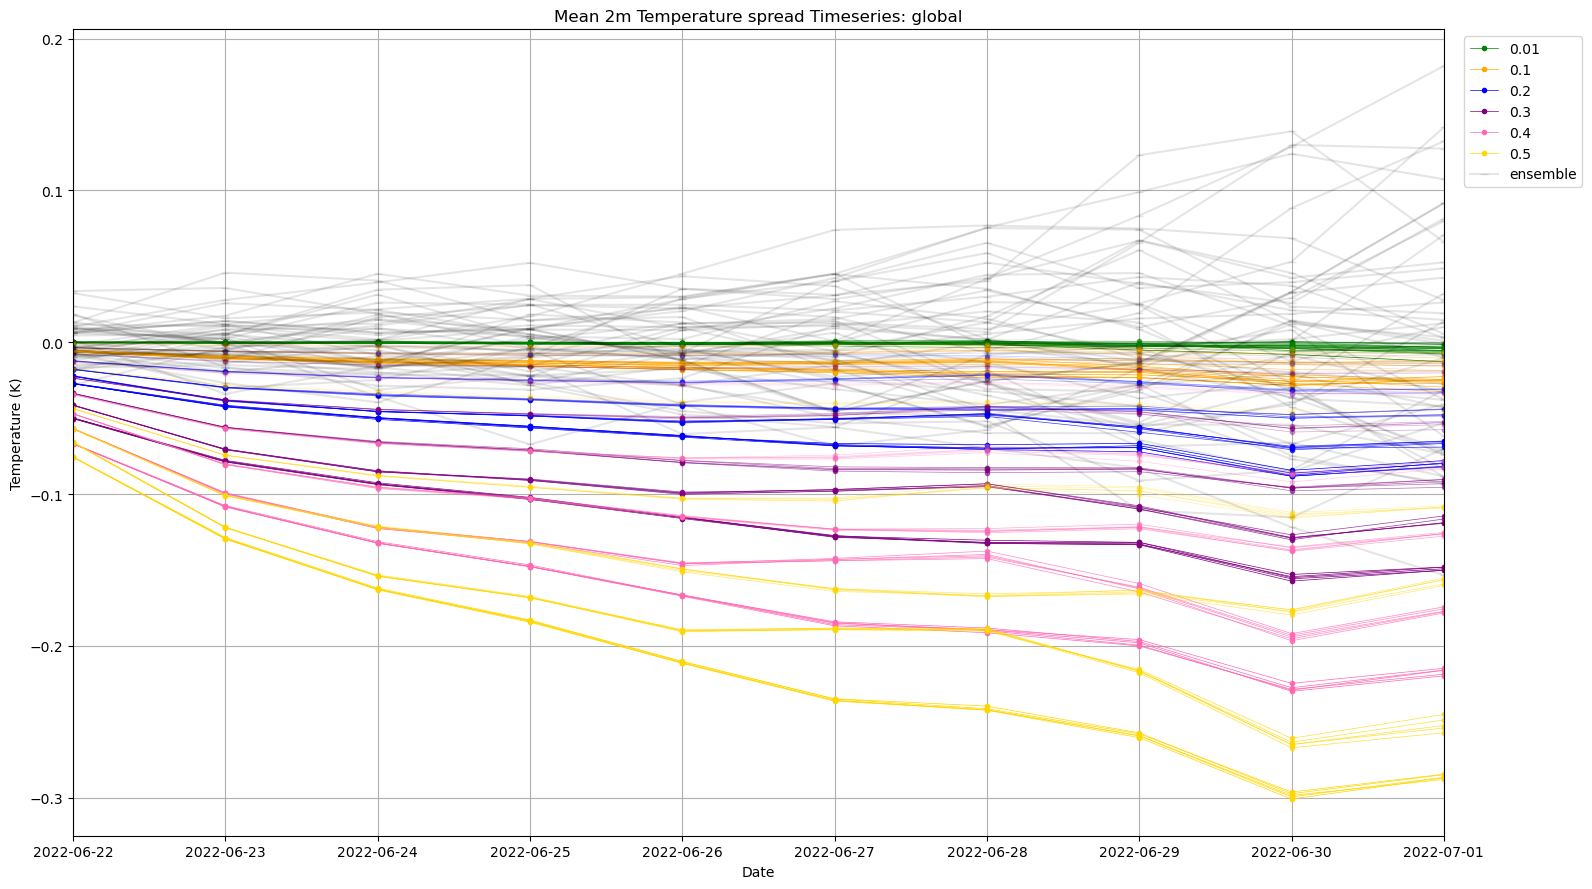

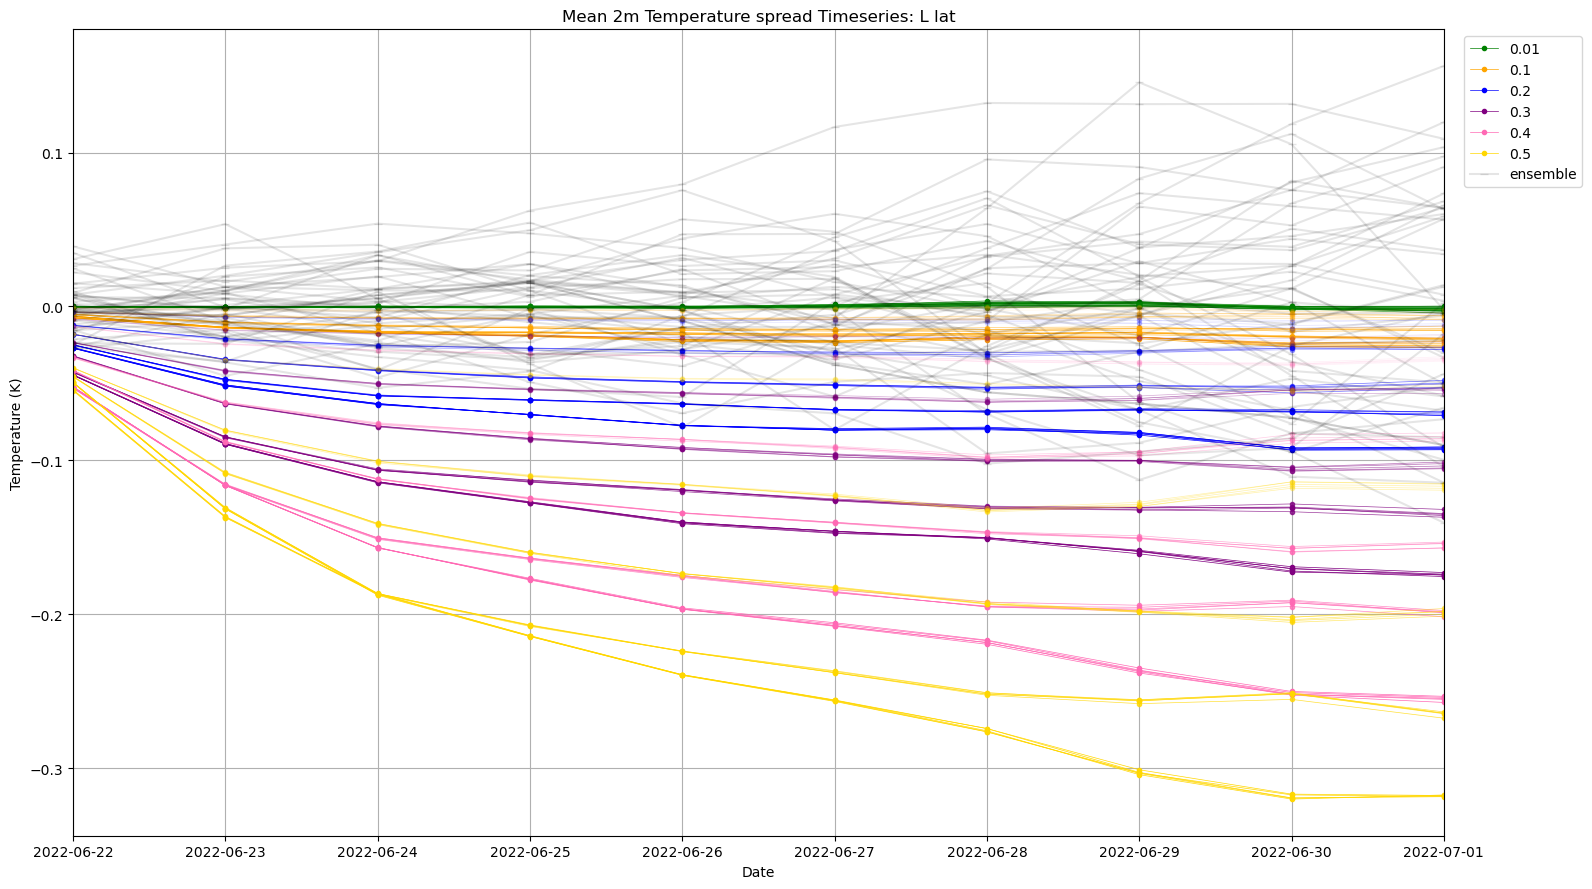

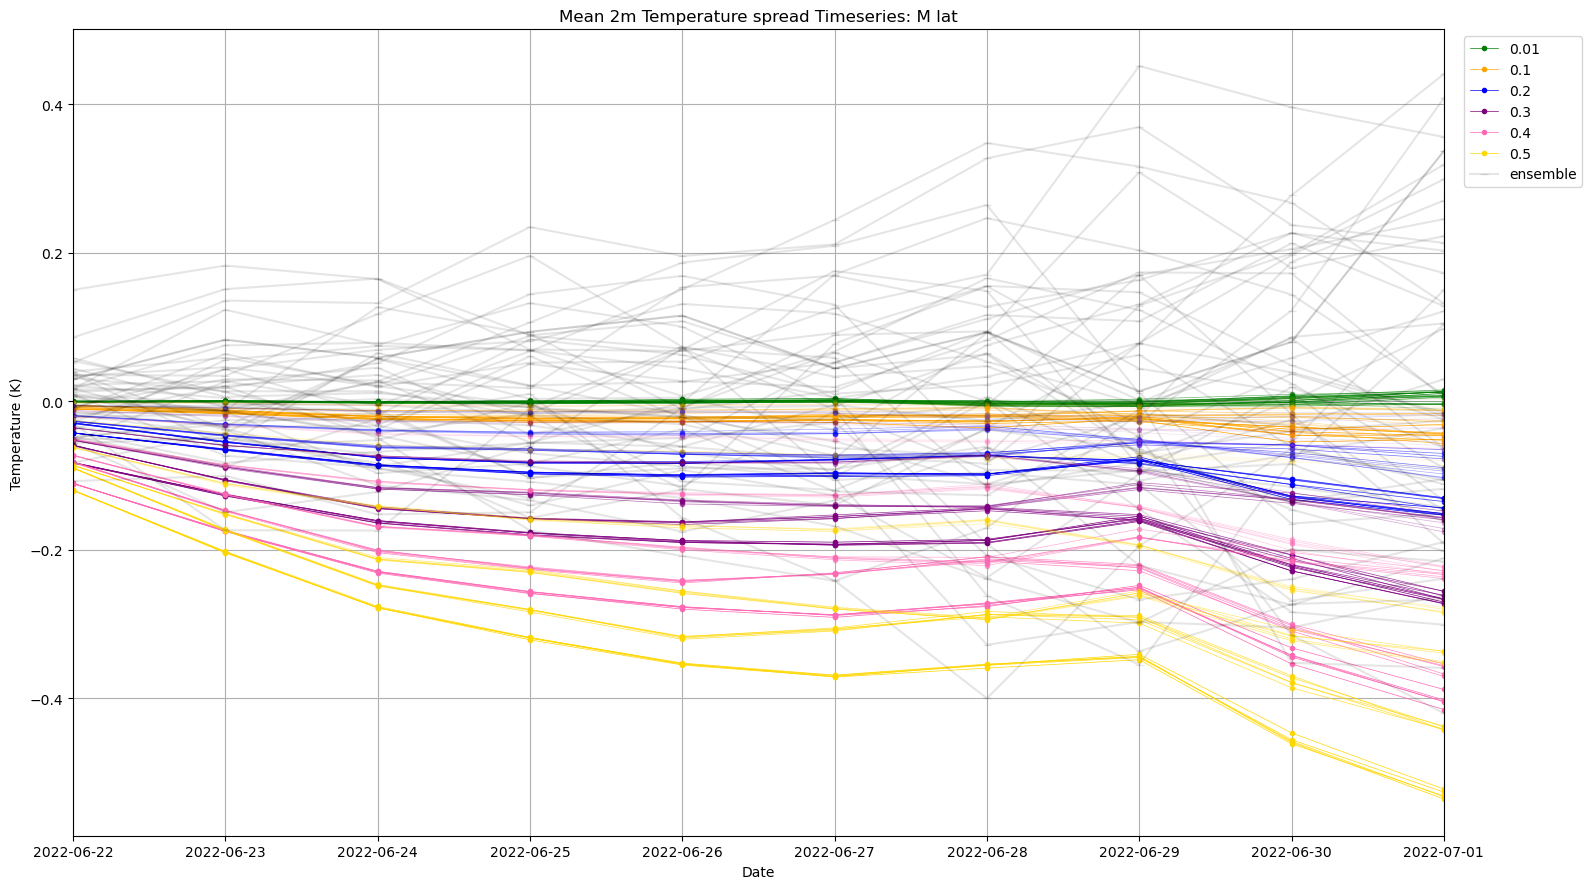

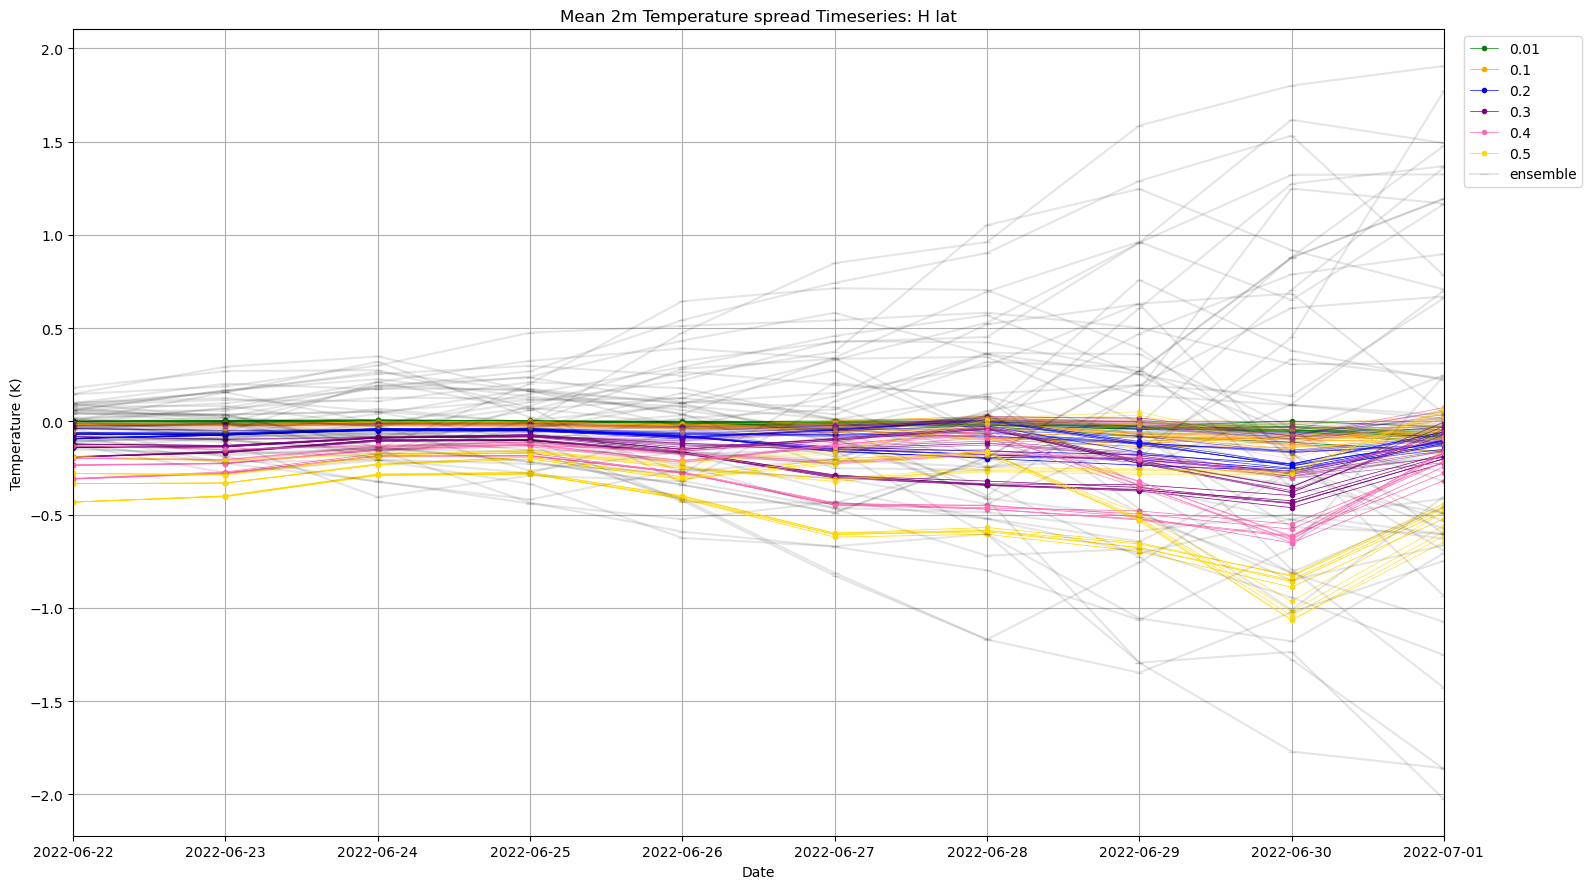

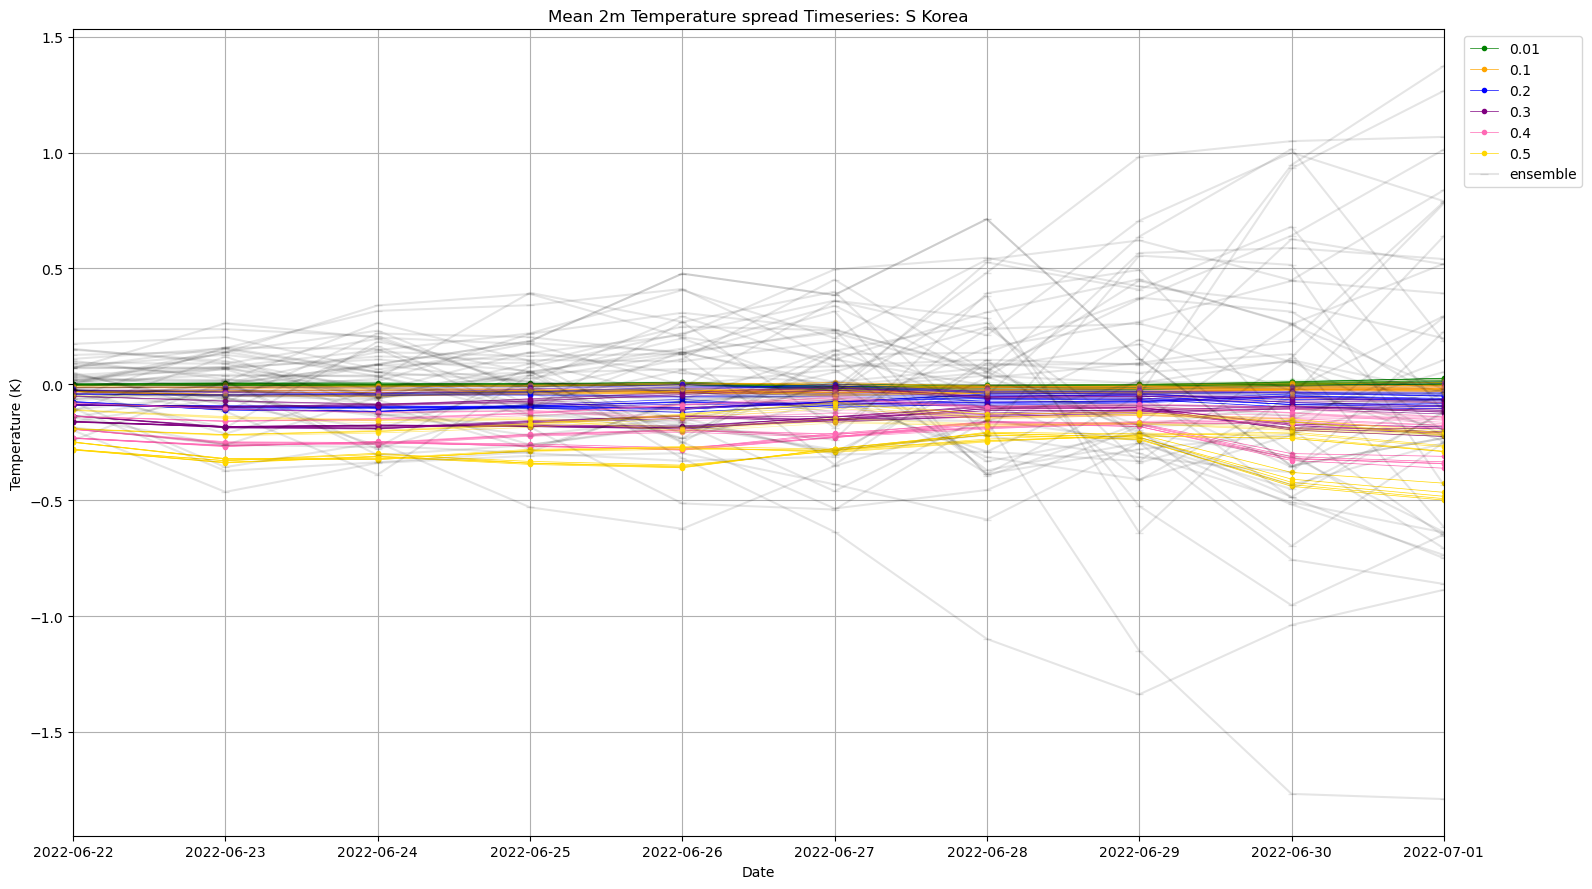

In [26]:
#@ plot3 date - spread

for region in ["global", "L lat", "M lat", "H lat", "S Korea"]:
# for target_var in ["2m_temperature", "geopotential"]:
    target_var = "2m_temperature"   
    title = f'Mean 2m Temperature spread Timeseries: {region}'
    unit = 'Temperature (K)'

    plt.figure(figsize=(16, 9))
    plt.title(title)
    plt.xlabel("Date")
    # x axis: 2022-06-22 ~ 2022-06-28
    date = pd.date_range(start='2022-06-22', end='2022-07-01')
    plt.xlim(date[0], date[-1])
    plt.ylabel(unit)

    # plt.scatter(40, 0.9, color=(1, 1, 1), label="std", marker='o')

    for i, (name, color, data) in enumerate(t2m_regional):
        # percent = int(name.split()[1].split("_")[1][0])*10
        # name = name.split()[1]
        # std = name.split("_")[0]
        scale = float(name.split("_")[0])
        num_values = int(name.split("_")[1])
        ens = int(name.split("_")[2][0])
        alpha = num_values/ 9
        # if float(std) > 0.5:
        #     continue
        if num_values == 9 and legend_shown==False:
            plt.plot(date, 
                     data[region]["2m_temperature"], 
                     color=mcolors.to_rgba(colors_list[scale_list.index(scale)], alpha), 
                     label=f"{scale}", 
                     marker='o', 
                     markersize=3, 
                     linewidth=0.5) # {std}-{percent}%
            legend_shown=True
        else:
            plt.plot(date, 
                     data[region]["2m_temperature"], 
                     color=mcolors.to_rgba(colors_list[scale_list.index(scale)], alpha),
                     marker='o', 
                     markersize=3, 
                     linewidth=0.5) 
        
        if ens == 4:
            legend_shown=False
        else:
            legend_shown=True

    legend_shown=False
    for i in range(nwp_dataset.sizes["ensemble"]):
        if not legend_shown:
            plt.plot(date, 
                     nwp_dataset.isel(ensemble=i).squeeze()[region],
                     color=(0.00001, 0.00001, 0.00001), 
                     label="ensemble", 
                     marker='_', 
                     alpha=.1)
            legend_shown=True
        plt.plot(date, 
                 nwp_dataset.isel(ensemble=i).squeeze()[region], 
                 color=(0.00001, 0.00001, 0.00001), 
                 marker='_', 
                 alpha=.1)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.grid(True)
    # plt.ylim(-0.01, 0.35)
    plt.subplots_adjust(right=0.85)
    plt.tight_layout()
    plt.show()
    # plt.savefig(f"sparse_shuffle_{target_var}_spread_{region}.png")